In [2]:
#Python
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#Regressor Models
from xgboost import XGBRegressor

# data processing
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

#Model Selection
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

#Otros
import optuna

#Pickle
import pickle


In [3]:
data=pd.read_csv('../../Data/data_top10.csv')
data.head()

,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,MI,FT,Data Scientist,111740,North America,0,North America,M
1,SE,FT,Data Scientist,115000,North America,100,North America,M
2,SE,FT,Machine Learning Engineer,112000,North America,0,North America,M
3,SE,FT,Machine Learning Engineer,194000,North America,100,North America,M
4,SE,FT,Data Scientist,187000,North America,0,North America,M


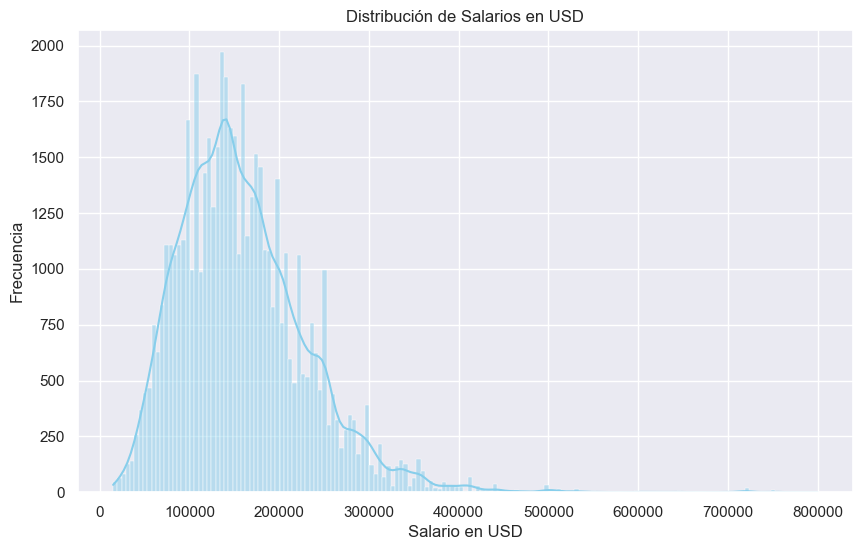

In [ ]:
sns.set(style="darkgrid")

# 1. Distribución de salarios en USD
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='salary_in_usd', kde=True, color="skyblue")
plt.title("Distribución de Salarios en USD")
plt.xlabel("Salario en USD")
plt.ylabel("Frecuencia")
plt.show()

C:\Users\WD\AppData\Local\Temp\ipykernel_22300\908351394.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x='job_title', y='salary_in_usd', estimator='mean', palette="viridis")


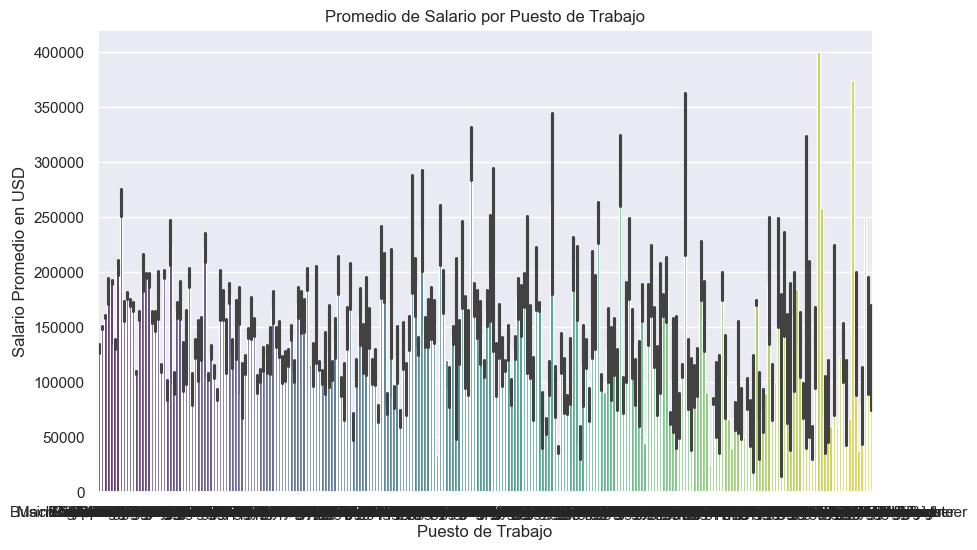

In [ ]:
#Frecuencia de experiencia por tipo de empleo
plt.figure(figsize=(10, 6))
sns.barplot(data=data, x='job_title', y='salary_in_usd', estimator='mean', palette="viridis")
plt.title("Promedio de Salario por Puesto de Trabajo")
plt.xlabel("Puesto de Trabajo")
plt.ylabel("Salario Promedio en USD")
plt.show()

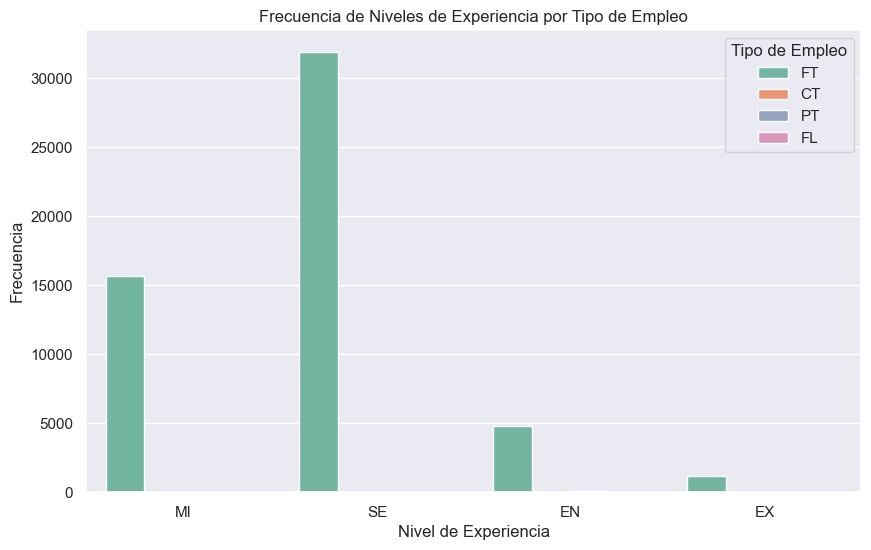

In [ ]:
# Frecuencia de experiencia por tipo de empleo
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='experience_level', hue='employment_type', palette="Set2")
plt.title("Frecuencia de Niveles de Experiencia por Tipo de Empleo")
plt.xlabel("Nivel de Experiencia")
plt.ylabel("Frecuencia")
plt.legend(title='Tipo de Empleo')
plt.show()

C:\Users\WD\AppData\Local\Temp\ipykernel_22300\3497633822.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='remote_ratio', palette="coolwarm")


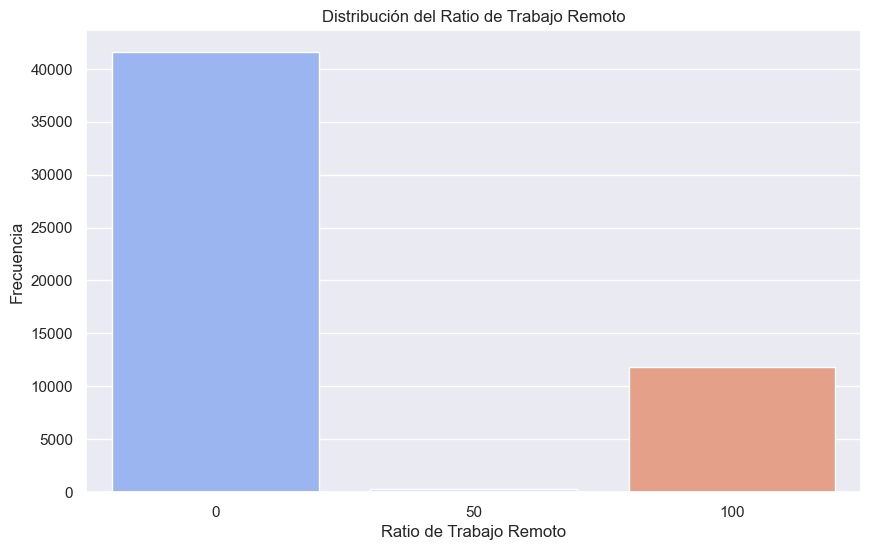

In [ ]:
# Distribución del ratio remoto
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='remote_ratio', palette="coolwarm")
plt.title("Distribución del Ratio de Trabajo Remoto")
plt.xlabel("Ratio de Trabajo Remoto")
plt.ylabel("Frecuencia")
plt.show()

In [5]:
Y=data['salary_in_usd']
X=data.drop(['salary_in_usd'],axis=1)

In [19]:
X

,experience_level,employment_type,job_title,employee_residence,remote_ratio,company_location,company_size
0,MI,FT,Data Scientist,North America,0,North America,M
1,SE,FT,Data Scientist,North America,100,North America,M
2,SE,FT,Machine Learning Engineer,North America,0,North America,M
3,SE,FT,Machine Learning Engineer,North America,100,North America,M
4,SE,FT,Data Scientist,North America,0,North America,M
...,...,...,...,...,...,...,...
11188,MI,FT,Manager,North America,0,North America,M
11189,SE,FT,Data Engineer,North America,100,North America,M
11190,SE,FT,Data Scientist,North America,100,North America,M
11191,MI,FT,Data Engineer,North America,100,North America,M


## XGBRegressor

In [7]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [9]:
# Preprocesamiento: codificación y escalado
# Listado de columnas


one_hot_encoded_cols = ['experience_level','employment_type', 'job_title', 'employee_residence', 'company_location', 'company_size','remote_ratio']

preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'), one_hot_encoded_cols)  # One-Hot Encoding
    ])


In [11]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBRegressor())
])
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['experience_level',
                                                   'employment_type',
                                                   'job_title',
                                                   'employee_residence',
                                                   'company_location',
                                                   'company_size',
                                                   'remote_ratio'])])),
                ('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              c...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

### Optuna

In [12]:
def objective(trial):
    # Espacio de búsqueda para los hiperparámetros de XGBRegressor
    params = {
        'model__n_estimators': trial.suggest_int('model__n_estimators', 50, 300),
        'model__learning_rate': trial.suggest_loguniform('model__learning_rate', 0.01, 0.3),
        'model__max_depth': trial.suggest_int('model__max_depth', 3, 10),
        'model__subsample': trial.suggest_uniform('model__subsample', 0.5, 1.0),
        'model__colsample_bytree': trial.suggest_uniform('model__colsample_bytree', 0.5, 1.0)
    }

    # Configurar el pipeline con los hiperparámetros sugeridos
    pipeline.set_params(**params)
    
    # Ajustar el pipeline en el conjunto de entrenamiento
    pipeline.fit(X_train, y_train)
    
    # Evaluar el modelo en el conjunto de prueba
    preds = pipeline.predict(X_test)
    rmse = mean_squared_error(y_test, preds, squared=False)  # RMSE como métrica objetivo
    
    return rmse  # Optuna minimiza esta métrica


In [13]:
# Crear un estudio de Optuna y ejecutar la optimización
study = optuna.create_study(direction='minimize', study_name='regression')
study.optimize(objective, n_trials=100)

[I 2024-10-30 19:46:23,308] A new study created in memory with name: regression
C:\Users\WD\AppData\Local\Temp\ipykernel_23228\564064985.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'model__learning_rate': trial.suggest_loguniform('model__learning_rate', 0.01, 0.3),
C:\Users\WD\AppData\Local\Temp\ipykernel_23228\564064985.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'model__subsample': trial.suggest_uniform('model__subsample', 0.5, 1.0),
C:\Users\WD\AppData\Local\Temp\ipykernel_23228\564064985.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float

In [ ]:
# Resultados de la optimización
print("Mejores hiperparámetros:", study.best_params)
print("Mejor RMSE:", study.best_value)

# Obtener el mejor pipeline ajustado
best_pipeline = pipeline.set_params(**study.best_params)
best_pipeline.fit(X_train, y_train)

# Evaluar el pipeline final en el conjunto de prueba
final_preds = best_pipeline.predict(X_test)
final_rmse = mean_squared_error(y_test, final_preds, squared=False)
print(f"RMSE del mejor modelo en conjunto de prueba: {final_rmse:.2f}")

Mejores hiperparámetros: {'model__n_estimators': 111, 'model__learning_rate': 0.09728953282259685, 'model__max_depth': 3, 'model__subsample': 0.8996601455749917, 'model__colsample_bytree': 0.9253258000110266}
Mejor RMSE: 56023.91427630378
RMSE del mejor modelo en conjunto de prueba: 56023.91


c:\Users\WD\.conda\envs\VSCEnv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Random Forest Regressor